In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import os

%matplotlib inline

## Abstract

Seemingly whimsical, the title of this project encloses the harsh reality of how astoundingly primitive we are in the 21st century and how little has actually changed since Medieval times. We attempt to modernise our society in many aspects, invent new technology to make everyday life more pleasant, but at the end of the day, we witness so much violence, intolerance and hatred. Independent of the fact whether it is an inter-country conflict for territory, an organisation requesting rights, a state or region fighting for independence, the truth is these clashes result in numerous casualties, direct or collateral, ruined societies, destroyed lives and terrible loss. And there are much more sparkles on the edge of kindling a fire.

The goal of this project is to make an attempt at uncovering the shocking reality about world conflicts that few people know about because it may not be or have been in the spotlight. Hopefully, observing the aggregated information visualised in a nicely presentable way will help raise awareness of what has been happening in recent history or at the present moment, and bring incentive to start building an improved version of the World.

## Loading the data and getting familiar with it

In [603]:
DATA_PATH = './data/'

# Primary datasets of interest
ucdp_ged_global_file = os.path.join(DATA_PATH + 'ged171.csv')
ucdp_armed_conflicts_file = os.path.join(DATA_PATH + 'ucdp-prio-acd-171.csv')
ucdp_battle_deaths_file = os.path.join(DATA_PATH + 'ucdp-brd-conf-171.csv')

# Additional datasets
ucdp_conflict_offset_file = os.path.join(DATA_PATH + 'ucdp-onset-conf-2014.csv')

# Metadata datasets
ucdp_actor_list_file = os.path.join(DATA_PATH + 'actorlist.csv')
gleditsch_ward_file = os.path.join(DATA_PATH + 'gleditsch-ward.txt')

### UCDP Georeferenced Event Dataset (GED) Global version 17.1 (2016)

This dataset is UCDP's most disaggregated dataset, covering individual events of organized violence (phenomena of lethal violence occurring at a given time and place). These events are sufficiently fine-grained to be geo-coded down to the level of individual villages, with temporal durations disaggregated to single, individudal days.

The basic unit of analysis for the UCDP GED dataset is the “event”, i.e. an individual incident (phenomenon) of lethal violence occurring at a given time and place. The dataset covers the entire World (except Syria) between 01.01.1989 and 31.12.2016.

Data in the UCDP GED is geo-referenced, meaning that each event is connected to a specific location defined by a pair of latitude and longitude coordinates. Each event is connected to a single location.

This dataset will be useful in tackling the research questions proposed for the project concerning the number of battle-related deaths for a particular location, the casualties suffered by each of the opposing sides in a conflict, but also civilians, and it will help us precisely pinpoint the locations of the battle sites that resulted in a significant amount of victims.

In terms of battle-related deaths, this dataset is a better option than the UCDP Battle-Related Deaths Dataset to get a more precise number on the losses suffered by each opposing side as it gives a disaggregated per-event number of casualties instead of an annual sum. It also provides information of the territory on which the deaths were registered.


<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>year</td>
        <td>int</td>
        <td>The year of the event</td>
    </tr>
    <tr>
        <td>active_year</td>
        <td>int (categorical)</td>
        <td>If the event belongs to an active conflict/dyad/actor-year or otherwise.</td>
    </tr>
    <tr>
        <td>type_of_violence</td>
        <td>int (categorial)</td>
        <td>Type of UCDP conflict: state-based conflict, non-state conflict or one-sided violence</td>
    </tr>
    <tr>
        <td>conflict_name</td>
        <td>string</td>
        <td>Name of the UCDP conflict to which the event belongs. For non-state conflicts and one-sided violence this is the same as the dyad name</td>
    </tr>
    <tr>
        <td>dyad_new_id</td>
        <td>int</td>
        <td>A unique conflict identification code for each individual dyad in the dataset.</td>
    </tr>
    <tr>
        <td>dyad_name</td>
        <td>string</td>
        <td>Name of the conflict dyad creating the event. A definition of <i>dyad</i> is provided in the following section.</td>
    </tr>
    <tr>
        <td>side_a</td>
        <td>string</td>
        <td>The name of Side A in the dyad. In state-based conflicts always a government. In one-sided violence always the perpetrating party.</td>
    </tr>
    <tr>
        <td>side_b</td>
        <td>string</td>
        <td>The name of Side B in the dyad. In state-based always the rebel movement or rivalling government. In one-sided violence always “civilians”.</td>
    </tr>
    <tr>
        <td>where_prec</td>
        <td>int (categorical)</td>
        <td>The precision with which the coordinates and location assigned to the event reflects the location of the actual event.</td>
    </tr>
    <tr>
        <td>where_coordinates</td>
        <td>string</td>
        <td>Name of the location to which the event is assigned.</td>
    </tr>
    <tr>
        <td>adm_1</td>
        <td>string</td>
        <td>Name of the first order (largest) administrative division where the event took place.</td>
    </tr>
    <tr>
        <td>adm_2</td>
        <td>string</td>
        <td>Name of the second order administrative division where the event took place.</td>
    </tr>
    <tr>
        <td>latitude</td>
        <td>numeric</td>
        <td>Latitude (in decimal degrees).</td>
    </tr>
    <tr>
        <td>longitude</td>
        <td>numeric</td>
        <td>Longitude (in decimal degrees).</td>
    </tr>
    <tr>
        <td>country</td>
        <td>string</td>
        <td>Name of the country in which the event takes place.</td>
    </tr>
    <tr>
        <td>region</td>
        <td>string (categorical)</td>
        <td>Region where the event took place. One of following: Africa, Americas, Asia, Europe, Middle East.</td>
    </tr>
    <tr>
        <td>date_start</td>
        <td>date(YYYY-MM-DD)</td>
        <td>The earliest possible date when the event has taken place.</td>
    </tr>
    <tr>
        <td>date_end</td>
        <td>date(YYYY-MM-DD)</td>
        <td>The last possible date when the event has taken place.</td>
    </tr>
    <tr>
        <td>deaths_a</td>
        <td>integer</td>
        <td>The best estimate of deaths sustained by side a. Always 0 for one-sided violence events.</td>
    </tr>
    <tr>
        <td>deaths_b</td>
        <td>integer</td>
        <td>The best estimate of deaths sustained by side b. Always 0 for one-sided violence events</td>
    </tr>
    <tr>
        <td>deaths_civilians</td>
        <td>integer</td>
        <td>The best estimate of dead civilians in the event. For non-state or state-based events, this is the number of collateral damage resulting in fighting between side a and side b. For one-sided violence, it is the number of civilians killed by side a.</td>
    </tr>
    <tr>
        <td>deaths_unknown</td>
        <td>integer</td>
        <td>The best estimate of deaths of persons of unknown status.</td>
    </tr>
    <tr>
        <td>best_est</td>
        <td>integer</td>
        <td>The best (most likely) estimate of total fatalities resulting from an event. It is always the sum of deaths_a, deaths_b, deaths_civilians and deaths_unknown.</td>
    </tr>
    <tr>
        <td>high_est</td>
        <td>integer</td>
        <td>The highest reliable estimate of total fatalities.</td>
    </tr>
    <tr>
        <td>low_est</td>
        <td>integer</td>
        <td>The lowest reliable estimate of total fatalities.</td>
    </tr>
</table>

A large number of the variables presented in the table reappear in the other datasets as well and will not be analysed again later, unless there is a change in the name of the variable, the semantics or the methodology how its value was collected.

<b>2. Terminology and definitions</b>

This subsection attempts to clarify some of the prerequisites and terminology required to better understand the provided data and to interpret the results more accurately.

  * <b>Event</b> = <i>An incident where armed force was by an <b>organised actor</b> against <b>another organized actor, or against civilians, resulting in at least 1 direct death</b> at a <b>specific location</b> and a <b>specific date</b></i>
  * <b>Armed force</b> = <i>Use of arms in order to promote the parties’ general position in the conflict, resulting in deaths</i>
  * <b>Organized actor</b> = <i>A government of an independent state, a formally organized group or an informally organized group</i>
  * <b>Dyad</b> = <i>A dyad is the <b>pair of two armed and opposing actors engaged in violence</b> (in the case of one-sided violence, the perpetrator of violence and civilians).</i>
  * <b>Active conflict</b> = <i>A conflict, both state-based and non-state, is deemed to be active if there are <b>at least 25 battle-related deaths per calendar year</b> in one of the conflict’s dyads.</i>
  * <b>Incompatibility</b> = <i>The stated (in writing or verbally) generally incompatible positions.</i>

In [35]:
# Map certain column values into more meaningful categories
active_year_map = {
    1: 'active',
    0: 'non-active'
}

type_of_violence_map = {
    1: 'state-based',  # government vs. formally organised group
    2: 'non-state',  # formally organised group vs. formally organised group OR informally organised group vs. formally organised group
    3: 'one-sided'  # formally organised group vs. civilians
}

where_prec_map = {
    1: 'exact',
    2: '25km radius',
    3: 'second order administrative division',  # district, municipality or commune
    4: 'first order administrative division',  # province, state or governorate
    5: 'linear region',  # along a border or a river
    6: 'country',
    7: 'international waters'
}

ged_global_columns = ['year', 'active_year', 'type_of_violence', 
                      'conflict_new_id', 'conflict_name', 'dyad_new_id', 'dyad_name',
                      'side_a_new_id', 'side_b_new_id', 'where_prec', 'where_coordinates',
                      'adm_1', 'adm_2', 'latitude', 'longitude', 'country', 'region',
                      'date_start', 'date_end', 'deaths_a', 'deaths_b', 'deaths_civilians',
                      'deaths_unknown', 'best', 'low', 'high'
                     ]

In [569]:
ged_global_raw = pd.read_csv(ucdp_ged_global_file, sep=',', header=0, index_col='id', na_values=-99)
ged_global_raw.replace({
    'active_year': active_year_map,
    'type_of_violence': type_of_violence_map,
    'where_prec': where_prec_map
}, inplace=True)

ged_global_raw = ged_global_raw[ged_global_columns]

In [570]:
ged_global_raw.shape

(135181, 26)

In [575]:
ged_global_raw['conflict_new_id'].nunique()

997

The dataset contains 135'181 events of organised violence, which are part of a total of 997 unique conflicts that occurred during the period 1989-2016.

In [571]:
ged_global_raw.isnull().sum()

year                     0
active_year              0
type_of_violence         0
conflict_new_id          0
conflict_name            0
dyad_new_id              0
dyad_name                0
side_a_new_id            0
side_b_new_id            0
where_prec               0
where_coordinates        0
adm_1                 7060
adm_2                35871
latitude                 0
longitude                5
country                  0
region                   0
date_start               0
date_end                 0
deaths_a                 0
deaths_b                 0
deaths_civilians         0
deaths_unknown           0
best                     0
low                      0
high                     0
dtype: int64

It is very important that the dataset does not have missing values for the key attributes that we intend to use. Those are the ones related to geographical location of the conflict event and battle-related deaths.

### UCDP Actor List

A simple list of all the actors (including their full names and alternate names) as available in UCDP datasets version 17.1.

This dataset will be very useful in the process of mapping the acronyms of many organised groups to their full names.

In [593]:
actor_list_raw = pd.read_csv(ucdp_actor_list_file, sep=',', header=0, index_col='ActorID')

In [594]:
actor_list_raw.shape

(1687, 2)

In [595]:
actor_list_raw.isnull().sum()

Name         0
NameFull    26
dtype: int64

The full dataset consists of 1'687 actors, each described with a unique ID, a name and a full name. However, 26 of the actors are missing a value for the full name entry. In order to cope with this issue in advance, rather than check if the values exist later in the analysis, the `Name` value will be copied to the `NameFull` column wherever there is a missing value.

In [596]:
nan_row_indices = actor_list_raw[actor_list_raw['NameFull'].isnull()].index
actor_list_raw.loc[nan_row_indices, 'NameFull'] = actor_list_raw.loc[nan_row_indices, 'Name']
actor_list_raw.loc[nan_row_indices]

,Name,NameFull
ActorID,,
3821,"France, Israel, United Kingdom","France, Israel, United Kingdom"
3823,"Egypt, Iraq, Jordan, Lebanon, Syria","Egypt, Iraq, Jordan, Lebanon, Syria"
3835,"Bokora Karimojong, Pian Karimojong","Bokora Karimojong, Pian Karimojong"
3856,"Lendu, RCD-K-ML","Lendu, RCD-K-ML"
3864,"Serbian irregulars, Serbian Republic of Bosnia...","Serbian irregulars, Serbian Republic of Bosnia..."
3881,"Afar, Oromo","Afar, Oromo"
3883,"Supporters of ANC, Supporters of UDF","Supporters of ANC, Supporters of UDF"
3894,"Goldia, Mursi","Goldia, Mursi"
3898,"Forces of Hasan, Musa Shajik","Forces of Hasan, Musa Shajik"


### UCDP/PRIO Armed Conflict Dataset version 17.1

A conflict-year dataset with information on armed conflicts where at least one party is the government of a state in the time period 1946-2016.

The main unit in this dataset is an “Armed Conflict” as defined by UCDP. Each conflict is listed in the database and given a unique ID code. The definition of armed conflict is given in the Terminology and definitions section below.

The observation (or unit) in the Main Conflict table is the conflict-year. Each conflict is listed in all years where fighting in one or more dyad(s) caused at least 25 battle-related deaths.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>location</td>
        <td>string</td>
        <td>The name(s) of the country/countries whose government(s) have a primary claim to the issue in dispute. Location is defined as the government side of a conflict, and should not be interpreted as the geographical location of the conflict.</td>
    </tr>
    <tr>
        <td>Incomp</td>
        <td>int (categorical)</td>
        <td>A general coding of the conflict issue. The possible values are: territory, government, and government and territory.</td>
    </tr>
    <tr>
        <td>int</td>
        <td>int (categorical)</td>
        <td>The intensity level in the dyad per calendar year. Two different intensity levels are coded: minor armed conflicts and wars.</td>
    </tr>
    <tr>
        <td>cumint</td>
        <td>int (categorical)</td>
        <td>The intensity of the conflict, taking into consideration the conflict history. Indicates whether the conflict since the onset has exceeded 1,000 battle-related deaths.</td>
    </tr>
    <tr>
        <td>type</td>
        <td>int (categorical)</td>
        <td>Four different types of conflict: extrasystemic, interstate, internal and internationalized internal.</td>
    </tr>
    <tr>
        <td>startdate</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, of the first battle-related death in the conflict.</td>
    </tr>
    <tr>
        <td>startdate2</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, when a given episode of conflict activity reached 25 battle-related deaths in a year.</td>
    </tr>
    <tr>
        <td>ependate</td>
        <td>date (YYYY-MM-DD)</td>
        <td>The date, as precise as possible, when conflict activity ended.</td>
    </tr>
    <tr>
        <td>region</td>
        <td>int (categorical)</td>
        <td>Identifying the region of the location.</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * <b>Armed conflict</b> = <i>a contested incompatibility that concerns government and/or territory where the use of armed force between two parties, of which at least one is the government of a state, results in <b>at least 25 battle-related deaths</b> in one calendar year. “Armed conflict” is also referred to as “state-based conflict”, as opposed to “non-state conflict”, in which none of the warring parties is a government.</i>
  * <b>Minor conflict</b> = <i>Between 25 and 999 battle-related deaths in a given year.</i>
  * <b>War</b> = <i>At least 1,000 battle-related deaths in a given year.</i>
  * <b>Extrasystemic armed conflict</b> = <i>Occurs between a state and a non-state group outside its own territory. These conflicts are by definition territorial, since the government side is fighting to retain control of a territory outside the state system.</i>
  * <b>Interstate armed conflict</b> = <i>Occurs between two or more states.</i>
  * <b>Internal armed conflict</b> = <i>Occurs between the government of a state and one or more internal opposition group(s) without intervention from other states.</i>
  * <b>Internationalized internal armed conflict</b> = <i>Occurs between the government of a state and one or more internal opposition group(s) with intervention from other states (secondary parties) on one or both sides.</i>

In [96]:
# Map certain column values into more meaningful categories
incomp_map = {
    1: 'territory',
    2: 'government',
    3: 'government and territory'
}

intensity_map = {
    1: 'minor',  # between 25 and 999 battle-related deaths in a given year
    2: 'war'  # at least 1'000 battle-related deaths in a given year
}

cumint_map = {
    0: 'minor',  # between 25 and 999 battle-related deaths for the entire conflict period
    1: 'war'  # more than 1'000 battle-related deaths for the entire conflict period
}

type_map = {
    1: 'extrasystemic',  # between a state and a non-state group outside its own territory
    2: 'interstate',  # between two or more states
    3: 'internal',  # between the government of a state and one or more internal opposition group(s) without intervention from other states
    4: 'internationalized'  # between the government of a state and one or more internal opposition group(s) with intervention from other states on one or both sides
}

region_map = {
    '1': 'Europe',
    '2': 'Middle East',
    '3': 'Asia',
    '4': 'Africa',
    '5': 'Americas'
}

armed_conflicts_columns = ['conflictid', 'location', 'sidea', 'side b' , 'sidebid',
                      'incomp', 'year', 'intensity', 'cumint', 'type',
                      'startdate', 'startdate2', 'ependdate', 'region'
                     ]

In [597]:
armed_conflicts_raw = pd.read_csv(ucdp_armed_conflicts_file, sep=',', header=0, na_values=-99)
armed_conflicts_raw.replace({
    'incomp': incomp_map,
    'intensity': intensity_map,
    'cumint': cumint_map,
    'type': type_map,
    'region': region_map
}, inplace=True)

# Handle the case where there are multiple regions in the same cell - all of them need to be mapped
for key in region_map.keys():
    armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.replace(r'(%s,?)' % (key), '%s,' % (region_map[key]))
armed_conflicts_raw['region'] = armed_conflicts_raw['region'].str.rstrip(',')

armed_conflicts_raw = armed_conflicts_raw[armed_conflicts_columns]
armed_conflicts_raw.shape

(2277, 14)

In [598]:
armed_conflicts_raw.head(10)

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
0,200,Bolivia,Government of Bolivia,Popular Revolutionary Movement,719,government,1946,war,war,internal,1946-07-18,1946-07-21,1946-07-21,Americas
1,200,Bolivia,Government of Bolivia,MNR,720,government,1952,minor,war,internal,1946-07-18,1952-04-09,1952-04-12,Americas
2,200,Bolivia,Government of Bolivia,ELN,721,government,1967,minor,war,internal,1946-07-18,1967-03-31,1967-10-16,Americas
3,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1946,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
4,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1947,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
5,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1948,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
6,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1949,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
7,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1950,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
8,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1951,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia
9,201,Cambodia (Kampuchea),Government of France,Khmer Issarak,160,territory,1952,minor,minor,extrasystemic,1946-08-31,1946-08-31,NaN,Asia


In [599]:
armed_conflicts_raw['conflictid'].nunique()

280

The Armed Conflict Dataset contains a total of 2'277 rows described by 27 attributes. Since the included data revolves around the concept of a `conflict`, multiple rows in the dataset describing one particular episode may refer to the same conflict which is primarily identified by the incompatibility between the opposing sides. Therefore, the `conflictid` column values are not unique. In fact, the dataset describes a total of 280 unique conflicts in the period 1946-2016.

In [600]:
armed_conflicts_raw.isnull().sum()

conflictid       0
location         0
sidea            0
side b           0
sidebid          0
incomp           0
year             0
intensity        0
cumint           0
type             0
startdate        0
startdate2       0
ependdate     1753
region           0
dtype: int64

The dataset does not include unclear conflicts where information on key variables to the definition of conflict is uncertain or missing. Key variables are those related to the incompatibility, actors and intensity.

### UCDP Battle-Related Deaths Dataset

Each entry in the dataset contains one side A (the contested party) and one or more contesters in a given year (each entry being one contested incompatibility) over the period 1989-2016. Thus, each individual conflict has its individual entry.

The advantage of working with this dataset instead of just using UCDP Georeferenced Event Dataset (GED) Global version 17.1 (2016) is that it is much easier to obtain totals, visualise annual trends and build a timeline of the battle victims over the years.

The main purpose of including this dataset is to obtain an aggregated value of the battle-related deaths over the years a particular conflict was active. Therefore, the columns that are present in the previously loaded datasets and are not absolutely necessary for the conflict casualties analysis will be discarded.

<b>1. Dataset attributes</b>

<table>
    <tr>
        <th>Variable name</th>
        <th>Type</th>
        <th>Meaning</th>
    </tr>
    <tr>
        <td>BattleLocation</td>
        <td>string</td>
        <td>The name of the country/countries in which battle-related deaths have been reported in the conflict.</td>
    </tr>
</table>

<b>2. Terminology and definitions</b>

  * <b>Best estimate</b> = <i>The UCDP Best estimate consist of the aggregated most reliable numbers for all battle-related incidents during a year. If different reports provide different estimates, an examination is made as to what source is most reliable. If no such distinction can be made, UCDP as a rule include the lower figure given..</i>
  * <b>Low estimate</b> = <i>The UCDP Low estimate consists of the aggregated low estimates for all battle-related incidents during a year. If different reports provide different estimates and a higher estimate is considered more reliable, the low estimate is also reported if deemed reasonable.</i>
  * <b>High estimate</b> = <i>The UCDP High estimate consists of the aggregated high estimates for all battle-related incidents during a year as listed in UCDP GED. If different reports provide different estimates and a lower estimate is considered more or equally reliable, the high estimate is also reported if deemed reasonable. If there are incidents when there is some uncertainty about what parties have been involved, these are also included in the high estimate.</i>

In [457]:
battle_deaths_columns = ['ConflictID', 'Year', 'LocationInc', 'BdBest', 'BdLow', 'BdHigh', 'BattleLocation']

In [465]:
battle_deaths_raw = pd.read_csv(ucdp_battle_deaths_file, sep=',', header=0, na_values=-99)
battle_deaths_raw = battle_deaths_raw[battle_deaths_columns]
battle_deaths_raw.shape

(1113, 7)

In [466]:
battle_deaths_raw.head(10)

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
0,13349,2013,Myanmar (Burma),29,29.0,30,Myanmar (Burma)
1,13349,2014,Myanmar (Burma),37,37.0,203,Myanmar (Burma)
2,13349,2015,Myanmar (Burma),106,106.0,181,Myanmar (Burma)
3,13721,2015,Algeria,26,26.0,26,Algeria
4,13692,2001,"Afghanistan, United Kingdom, United States of ...",1490,1482.0,2259,Afghanistan
5,13641,2016,Nigeria,2213,2210.0,2311,Nigeria
6,13641,2015,Nigeria,1919,1916.0,2953,Nigeria
7,11342,2012,India,27,23.0,27,India
8,11342,2014,India,26,23.0,32,India
9,11344,2011,Sudan,145,145.0,145,Sudan


In [467]:
battle_deaths_raw['ConflictID'].nunique()

171

The Battle-Related Deaths Dataset contains a total of 1'113 rows. Much like in the case for the Armed Conflict Dataset, what defines a conflict are the incompatibilities between two sides, which means the `ConflictID` column does not necessarily contain unique values. In fact, the dataset describes a total of 171 unique conflicts in the period 1989-2016.

In [473]:
battle_deaths_raw[['BdBest', 'BdLow', 'BdHigh']].isnull().sum()

BdBest    0
BdLow     1
BdHigh    0
dtype: int64

The previous code snippet reveals there is a single NaN or missing value in the `BdLow` column and none in the other two numeric columns. Since it is only one case, it is feasible to examine it and set a value manually. There is no need for a general strategy.

In [474]:
battle_deaths_raw[battle_deaths_raw['BdLow'].isnull()]

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
384,299,2014,Syria,54547,NaN,63887,"Lebanon, Syria"


In [475]:
battle_deaths_raw[battle_deaths_raw['ConflictID'] == 299]

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
380,299,2016,Syria,27235,15664.0,27235,Syria
381,299,2011,Syria,965,912.0,1190,Syria
382,299,2012,Syria,38480,14893.0,38709,"Syria, Turkey"
383,299,2013,Syria,68503,7529.0,68503,"Iraq, Lebanon, Syria"
384,299,2014,Syria,54547,NaN,63887,"Lebanon, Syria"
385,299,2015,Syria,33967,20057.0,33967,"Jordan, Syria"


The missing values appears to concern the annual battle-deaths low estimate for a battle which was part of the war in Syria and that played out on Syrian and Lebanese territory during the year 2014. As the best estimate value is not missing, it would not cause significant damage to replace the missing with the `BdBest` from the same row. Setting `BdLow` to zero will cause too much of an offset. It can be clearly seen from the other years that the number of casualties is never even close to zero. On the other hand, it is obvious even without any analysis that there is no increasing or decreasing trend that can be used for the estimate, therefore the best option is to simply replace the value with the upper-bound, which is exactly the value of `BdBest`.

In [477]:
battle_deaths_raw.loc[384, 'BdLow'] = battle_deaths_raw.loc[384, 'BdBest']

In [484]:
battle_deaths_raw[['BdLow', 'BdBest', 'BdHigh']].quantile([0, 0.25, 0.5, 0.75, 1])

,BdLow,BdBest,BdHigh
0.00,6.0,25.0,24.0
0.25,52.0,55.0,80.0
0.50,168.0,179.0,272.0
0.75,699.0,751.0,1100.0
1.00,54547.0,68503.0,68503.0


In [485]:
battle_deaths_raw[['BdLow', 'BdBest', 'BdHigh']].sum()

BdLow     1121604.0
BdBest    1287186.0
BdHigh    1667203.0
dtype: float64

The rows of this output give 5 quantile values, among which the minimum (0% quantile) and the maximum (100% quantile) values for each column. The other statistics do not make much sense, since the data first needs to be aggregated in order to draw any significant conclusions. The minimum and the maximum represent the annual number of battle-related deaths for a single conflict based on the corresponding estimate (low, best or high).

The shocking figures are the ones for the sum of each of these three columns. The number of battle-related deaths over a period of 28 years (1989-2016) falls in the range [1'121'604, 1'667'203], with the best estimate being 1'287'186 deaths.

### UCDP Conflict Termination Dataset version 2-2015

As part of the first milestone, we mentioned that we would use the UCDP Conflict Termination Dataset version 2-2015 in order to enrich the datasets described above, but after a more detailed examination of the potential of the previously listed datasets, we decided they provide all the needed information for the scope of the project. It would be best to simply use the information of whether conflicts are active or not in a particular year, in addition to the date of the conflict offset. Going into the peace aggreements into too much detail might cause a loss of focus, which we do not want. Therefore, the UCDP Conflict Termination Dataset version 2-2015 will not be used.

### Summary of the data collection process

The subsections above represent an extensive analysis of the global conflicts datasets provided on the UCDP website. It is worth noticing that even though they are "real-world" datasets, they lack the disorder, chaoticity and general "messiness" that other datasets usually encompass. This is understandable if we look into the background, into the data collection process which was done by professionals, researchers who used well-precised methodologies and invested a non-negligible amount of work into the correctness of the provided data. Therefore, quite honestly, much of the standard preprocessing steps were unnecessary as they were either already applied or simply those issues were nonexistant.

For every dataset we explored whether any of the features of interest contained any missing values and luckily there was only one single case that required attention and a strategy to fill in some NaNs. Everything else boiled down to the analysis of the dataset size, the type of the variables, the ranges of the variables where we judged useful to have that information and the number of unique observed events.

As the data is rather small in its volume, quite comprehensible without the need of significant computational power, surprisingly clean and consistent, and very well documented and described, the biggest challenge was to get familiar with the terminology and the meaning of the features that are used to describe the data. After extensive reading of the so-called "codebooks" that accompany every dataset, we put together tables explaining the used variables accross the different datasets, stating the name, the type and a detailed meaning, as this is crucial to understand how and why some steps are made or some decisions are taken. Furthermore, we give definition of some of the jargon that is used throughout the project. For each dataset we also briefly discuss the necessity of it and the reasons it was chosen in terms of the intentions we have for the next milestone.

As stated in the abstract itself, the purpose of this project is to aggregate and analyse the data, draw conclusions and use different visualisation techniques in order to present them in a way that will make it very easy for the reader to understand the point. We will not dive into supervised or unsupervised learning techniques, but rather employ data visualisation such as graphs, network diagrams, maps and other plots to discover the relationships between the conflict actors, to collect and display all the information contained in the different datasets in one place.

## Conflict episode analysis on a regional aggregation basis

As a first step, we will use the Armed Conflict Dataset to obtain insight on the conflict activity in different geographical areas of the World. In this section we will explore the number and the kind of armed conflicts, judging by the intensity, on a regional level, which constitutes a territory size similar to an entire continent or large part of a continent, and in the next section we will dive deeper into a more granular analysis based on the location where the conflict episodes have occurred.

The Armed Conflict Dataset aggregates conflict areas into 5 regions: Asia, Africa, Middle East, Americas and Europe. Of course, there are certain conflicts that are not contained and localised within a single region, but span multiple regions. The following section explains how these issues are handled and presents the results nicely plotted.

In [124]:
regional_aggregation = armed_conflicts_raw['region'].value_counts()
regional_aggregation

Asia                                   944
Africa                                 687
Middle East                            313
Americas                               190
Europe                                 132
Europe, Asia                             4
Europe, Middle East                      3
Europe, Asia, Americas                   1
Europe, Americas                         1
Europe, Africa                           1
Europe, Middle East, Asia, Americas      1
Name: region, dtype: int64

In [251]:
region_intensity_aggregated = armed_conflicts_raw.groupby(by=['region', 'intensity']).size()
region_intensity_aggregated = region_intensity_aggregated.reset_index()
region_intensity_aggregated = region_intensity_aggregated.rename(columns={0: 'count'})

regional_war_count = region_intensity_aggregated[region_intensity_aggregated['intensity'] == 'war'].sort_values(by='count', ascending=False)[:5]
regional_war_count

,region,intensity,count
5,Asia,war,244
1,Africa,war,207
16,Middle East,war,82
3,Americas,war,41
7,Europe,war,33


The vast majority of conflict clashes, or more precisely 91.5%, are limited to a single region (which in this case does not strongly correspond to a continent). However, there are 11 conflict episodes where the locations were spanning over multiple regions - mostly two, with the exception of the 2003 interstate conflict between Australia, US, and UK on the one side and Iraq on the other, which involves Europe, Middle East, Asia, and the Americas.

In [123]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Asia']

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
117,214,"France, Thailand",Government of France,Government of Thailand,147,territory,1946,minor,minor,interstate,1946-05-07,1946-05-07,1946-11-17,"Europe, Asia"
853,276,"Indonesia, Netherlands",Government of Indonesia,Government of Netherlands,30,territory,1962,minor,minor,interstate,1962-01-15,1962-01-15,1962-09-21,"Europe, Asia"
1163,305,"China, Russia (Soviet Union)",Government of China,Government of Russia (Soviet Union),57,territory,1969,minor,minor,interstate,1969-03-02,1969-03-02,1969-12-31,"Europe, Asia"
2160,431,"Afghanistan, Russia (Soviet Union)",Government of Afghanistan,Government of Russia (Soviet Union),57,government,1979,minor,minor,interstate,1979-12-27,1979-12-27,1979-12-28,"Europe, Asia"


In [122]:
armed_conflicts_raw[armed_conflicts_raw['region'] == 'Europe, Middle East, Asia, Americas']

,conflictid,location,sidea,side b,sidebid,incomp,year,intensity,cumint,type,startdate,startdate2,ependdate,region
2104,420,"Australia, Iraq, United Kingdom, United States...","Government of Australia, Government of United ...",Government of Iraq,116,government,2003,war,war,interstate,2003-03-20,2003-03-23,2003-04-28,"Europe, Middle East, Asia, Americas"


Since the number of conflicts taking place in multiple regions is very small compared to the single-region ones, they will not be included in the plots, for simplicity sake and for better visualisation. 

In [208]:
def draw_pie_plot(values, labels, explode, colors, title, ax):
    ax.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=True, explode=explode, pctdistance=0.8, startangle=90, colors=colors)
    ax.axis('equal')
    ax.set_title(title)

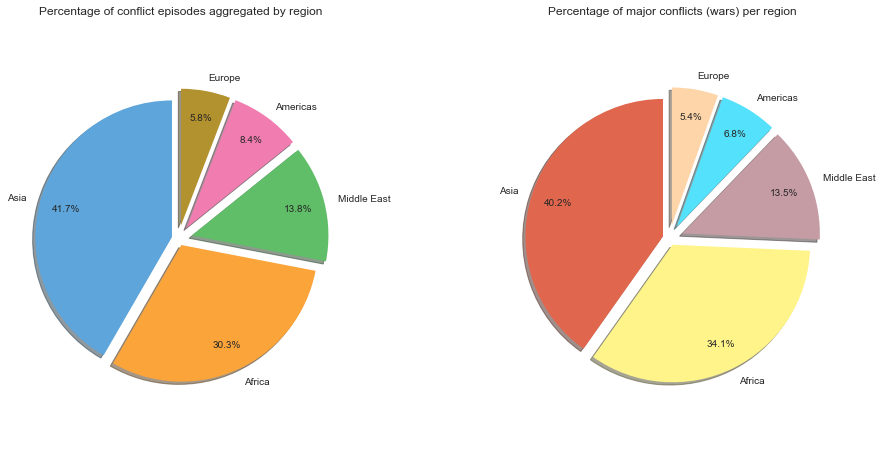

In [527]:
# Pie plot representing the regional distribution of conflict episodes
explode = (0.05, 0.05, 0.1, 0.1, 0.1)
colours1 = ["#5DA5DA", "#FAA43A", "#60BD68", "#F17CB0", "#B2912F"]
colours2 = ["#E0674D", "#FFF48A", "#C59BA4", "#54E1FC", "#FDD5A8"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 9))
fig.tight_layout()
plt.subplots_adjust(top=0.7, wspace = 0.5)
draw_pie_plot(regional_aggregation[:5].values, list(regional_aggregation[:5].keys()), explode, colours1, "Percentage of conflict episodes aggregated by region", ax[0])
draw_pie_plot(regional_war_count['count'], regional_war_count['region'], explode, colours2, 'Percentage of major conflicts (wars) per region', ax[1])
plt.show()

The above pie charts help visualise the total percentage of conflict episodes and the percentage of war events by region. The plot on the left takes into account the total number of conflict episodes registered in the period 1946-2016, regardless of their intensity, while the pie plot on the right focuses on the major incidents which resulted in more than 1'000 battle-related casualties.

The conclusion that can be drawn, judging by the numbers, is that the number of major incidents contributes almost equally to the total in every World region. There isn't a single region that perhaps had a relatively large share of conflicts, but all or the great majority of them being minor.

The only (barely) noticeable differences, that differ by more than one percent point, are Africa and the Americas. Africa has a larger share of wars than conflicts in general, while it is the opposite for the Americas region. This becomes more obvious from the stacked bar plot below, which shows that the percentage of wars over the total number of conflicts in Africa is 30%, which is larger than any other region where the ratio converges towards one quarter.

In [295]:
temp_total_count = regional_aggregation.reset_index().rename(columns={'region': 'count', 'index': 'region'}).sort_values(by='count', ascending=False)[:5]
regional_war_percentage = regional_war_count[['region', 'count']].merge(temp_total_count, on='region')
regional_war_percentage['war_percentage'] = regional_war_percentage['count_x'] / regional_war_percentage['count_y']
regional_war_percentage['total'] = 1
regional_war_percentage

,region,count_x,count_y,war_percentage,total
0,Asia,244,944,0.258475,1
1,Africa,207,687,0.301310,1
2,Middle East,82,313,0.261981,1
3,Americas,41,190,0.215789,1
4,Europe,33,132,0.250000,1


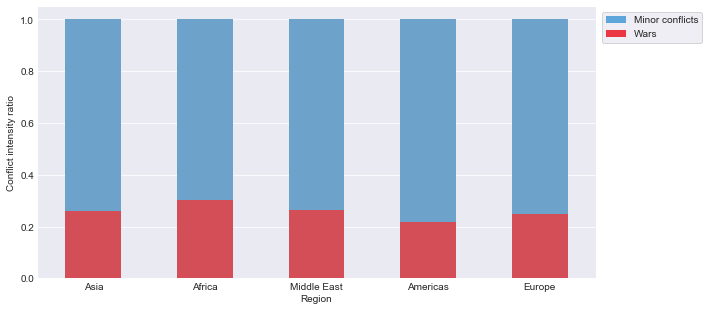

In [602]:
#Set general plot properties
sns.set_style('darkgrid')
sns.set_context({"figure.figsize": (10, 5)})

#Plot 1 - background - "total" (top) series
sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['total'], color = "#5DA5DA")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(x = regional_war_percentage['region'], y = regional_war_percentage['war_percentage'], color = "#EB3744")

# Reduce the width of the bars
for patch in bottom_plot.patches:
    current_width = patch.get_width()
    diff = current_width - 0.5

    # we change the bar width
    patch.set_width(0.5)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)


# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol = 1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_ylabel("Conflict intensity ratio")
bottom_plot.set_xlabel("Region")

plt.show()

The plot shows the percentage of armed conflict events that resulted in more than 1'000 deaths opposed to the minor conflicts, aggregated by region. Only the single region events are shown, since the cases of multiregional events are insignificantly small and will only decrease the clarity of the visualisation.

The figure below shows the regional absolute count per intensity level.

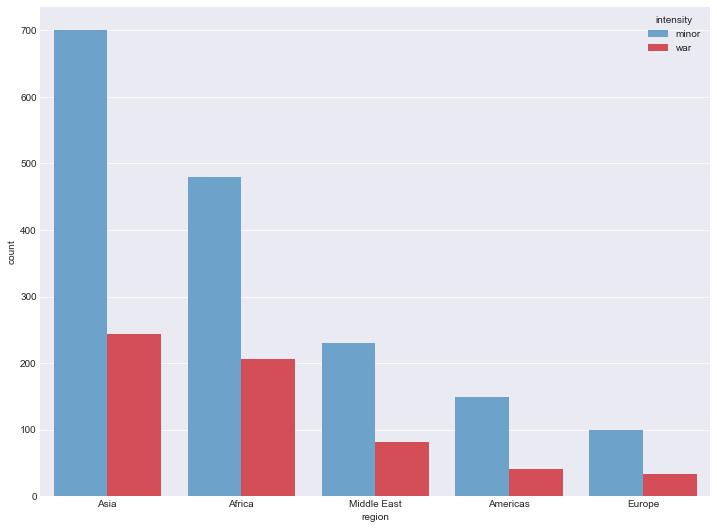

In [522]:
values = region_intensity_aggregated.sort_values(by='count', ascending=False)[:10]

fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style('darkgrid')
ax = sns.barplot(x="region", y='count', hue="intensity", data=values, palette=["#5DA5DA", "#EB3744"])
plt.show()

The above bar plot shows the counts of conflict episodes split according to their severity, based on the UCDP definitions taking into account the number of battle-related deaths, i.e. minor conflicts or wars. Minor conflicts are conflict episodes where the number of deaths is between 25 and 999 (inclusive), whereas for an event to be considered a war the number of casualties must rise above 1'000.

## Conflict episode analysis on a location aggregation basis

In [387]:
# Count the number of conflict events grouped by location and intensity
location_aggregated = armed_conflicts_raw.groupby(by=['location', 'intensity']).size()
location_aggregated = location_aggregated.reset_index()
location_aggregated = location_aggregated.rename(columns={0: 'count'})
location_aggregated.head(10)

,location,intensity,count
0,Afghanistan,minor,4
1,Afghanistan,war,37
2,"Afghanistan, Russia (Soviet Union)",minor,1
3,"Afghanistan, United Kingdom, United States of ...",war,1
4,"Albania, United Kingdom",minor,1
5,Algeria,minor,23
6,Algeria,war,13
7,"Algeria, Morocco",minor,1
8,Angola,minor,24
9,Angola,war,25


There is one subtle issue that needs to be attended to. Namely, there are certain events that have taken place in multiple locations, as is the case with some of the rows visible above: `Afghanistan, Russia (Soviet Union)`; `Albania, United Kingdom`; `Algeria, Morocco`; etc. In order to get a precise count of armed conflict events that happened on the territory of each country, we split the location values to individual countries (separated by a comma) and then add the conflict count to the value of each participant country.

In [389]:
# Split the values of the location column on comma
# Set the columns to keep as indices
temp = pd.DataFrame(location_aggregated['location'].str.split(', ').tolist(), index=[location_aggregated['intensity'], location_aggregated['count']]).stack()
temp = temp.reset_index()[[0, 'intensity', 'count']].rename(columns={0: 'location'})
# Aggregate on the same criterion as before
location_aggregated = temp.groupby(by=['location', 'intensity']).sum().reset_index()
location_aggregated.head()

,location,intensity,count
0,Afghanistan,minor,5
1,Afghanistan,war,38
2,Albania,minor,1
3,Algeria,minor,24
4,Algeria,war,13


In [407]:
country_conflict_count = location_aggregated.groupby(by='location').sum()
country_conflict_top = country_conflict_count.sort_values(by='count', ascending=False).head(20)
country_conflict_top

,count
location,
Myanmar (Burma),271
India,194
Ethiopia,127
Philippines,100
Israel,84
Iraq,73
Colombia,53
Pakistan,52
Indonesia,51


The output represents a list of the top 20 countries on whose territory there were armed conflict episodes during the period 1946-2016, which surpassed the annual minimum of 25 battle-related deaths, regardless of whether it was a minor incident or war. Myanmar (Burma) is without doubt the most prominent country in terms of the number of incidents, but approximately 82% of the conflict episodes resulted in less than 1'000 deaths, therefore they are considered minor conflicts. More on the ratio of minor conflicts vs. wars is presented in the following part.

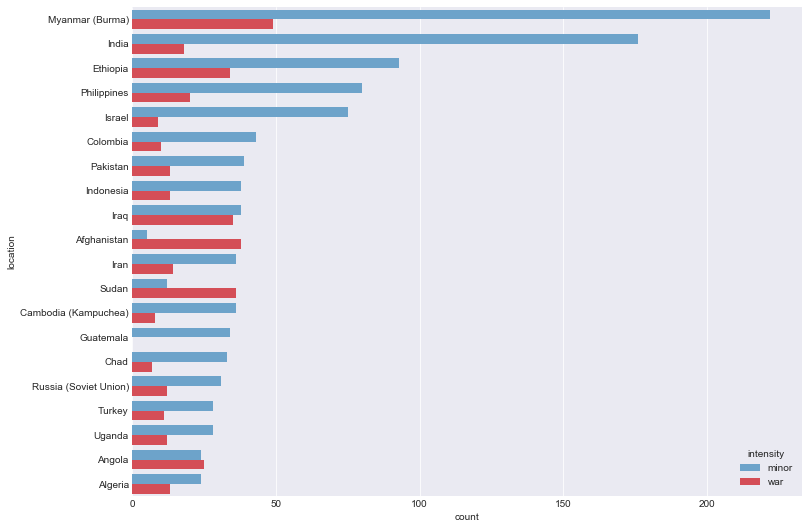

In [521]:
values = location_aggregated[location_aggregated['location'].isin(country_conflict_top.index)]

fig, ax = plt.subplots(figsize=(12, 9))
sns.set_style('darkgrid')
ax = sns.barplot(x="count", y='location', hue="intensity", orient='h', data=values.sort_values(by='count', ascending=False), palette=["#5DA5DA", "#EB3744"])
plt.show()

The figure shows the top 20 locations in the World with the largest number of conflict episode events. The total number is then broken down into two components based on the episode intensity level, namely into minor conflicts and wars. It can be easily seen that Myanmar (Burma) is in the lead, both in the number of minor conflicts and wars on its territory, even though the number of wars is significantly smaller compared to the number of minor conflicts.

It is also worth mentioning that Afghanistan, Sudan and Angola have a higher number of wars than minor incidents in their conflict history, with a percentage as high as 88% for Afghanistan and 75% for Sudan out of the total.

The proportion of war episodes in the total number of conflict events for the top locations is more explicitly presented in the following stacked bar plot figure.

In [453]:
location_war_count = location_aggregated[location_aggregated['intensity'] == 'war']
location_war_count = location_war_count[location_war_count['location'].isin(country_conflict_top.index)][['location', 'count']]

location_war_percentage = location_war_count.merge(country_conflict_top.reset_index(), on='location')
location_war_percentage['war_percentage'] = location_war_percentage['count_x'] / location_war_percentage['count_y']
location_war_percentage['total'] = 1

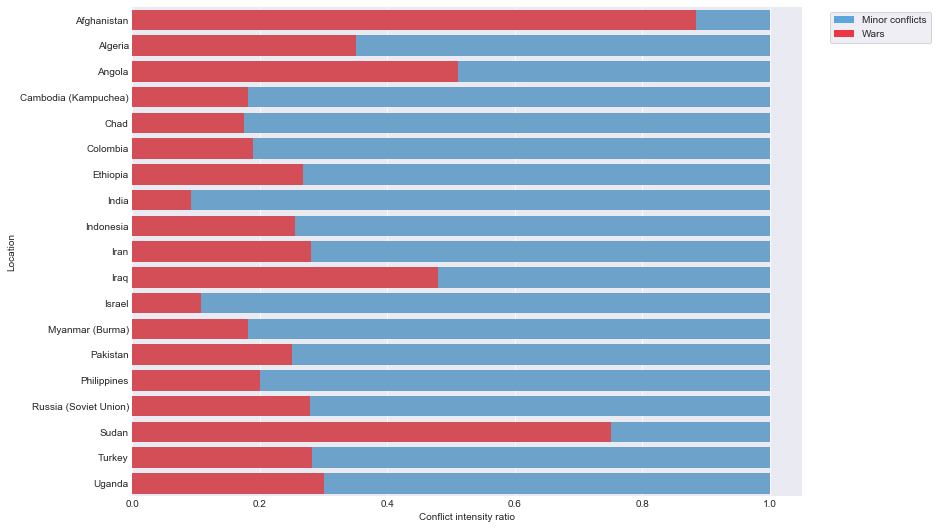

In [601]:
#Set general plot properties
sns.set_style('darkgrid')
sns.set_context({"figure.figsize": (12, 9)})

#Plot 1 - background - "total" (top) series
sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['total'], orient='h', color = "#5DA5DA")

#Plot 2 - overlay - "bottom" series
bottom_plot = sns.barplot(y = location_war_percentage['location'], x = location_war_percentage['war_percentage'], orient='h', color = "#EB3744")

# Create legend
topbar = plt.Rectangle((0,0), 1, 1, fc="#EB3744", edgecolor = 'none')
bottombar = plt.Rectangle((0,0), 1, 1, fc='#5DA5DA',  edgecolor = 'none')
l = plt.legend([bottombar, topbar], ['Minor conflicts', 'Wars'], loc=1, ncol=1, bbox_to_anchor=(1.2, 1))
l.draw_frame(True)

#Optional code - Make plot look nicer
sns.despine(left=True)
bottom_plot.set_xlabel("Conflict intensity ratio")
bottom_plot.set_ylabel("Location")

plt.show()

## Timeline of battle-related deaths

In [487]:
battle_deaths_raw.head(10)

,ConflictID,Year,LocationInc,BdBest,BdLow,BdHigh,BattleLocation
0,13349,2013,Myanmar (Burma),29,29.0,30,Myanmar (Burma)
1,13349,2014,Myanmar (Burma),37,37.0,203,Myanmar (Burma)
2,13349,2015,Myanmar (Burma),106,106.0,181,Myanmar (Burma)
3,13721,2015,Algeria,26,26.0,26,Algeria
4,13692,2001,"Afghanistan, United Kingdom, United States of ...",1490,1482.0,2259,Afghanistan
5,13641,2016,Nigeria,2213,2210.0,2311,Nigeria
6,13641,2015,Nigeria,1919,1916.0,2953,Nigeria
7,11342,2012,India,27,23.0,27,India
8,11342,2014,India,26,23.0,32,India
9,11344,2011,Sudan,145,145.0,145,Sudan


In [552]:
battle_deaths_per_year = battle_deaths_raw.groupby(by='Year')['BdLow', 'BdBest', 'BdHigh'].sum()
battle_deaths_per_year.tail()

,BdLow,BdBest,BdHigh
Year,,,
2012,37569.0,61773,68378
2013,28317.0,90389,100795
2014,101255.0,104755,126452
2015,77109.0,97874,111328
2016,66948.0,87266,98726


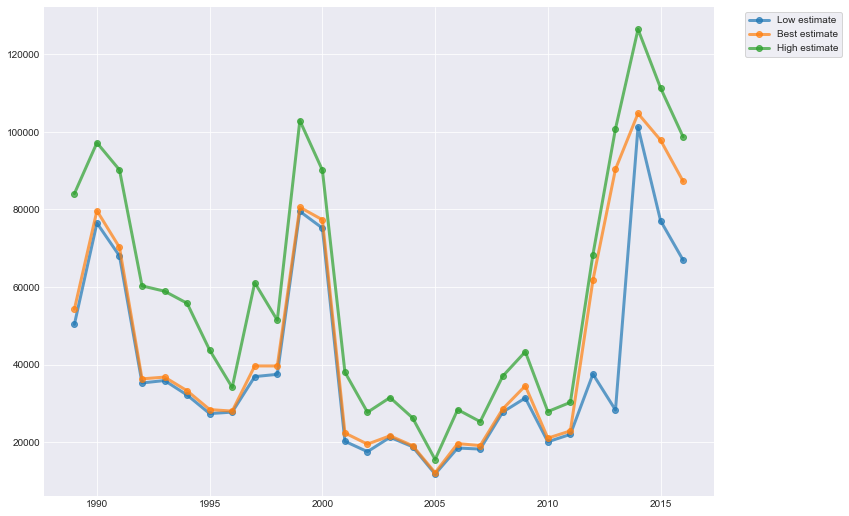

In [551]:
fig, ax = plt.subplots()
sns.set_style('darkgrid')
plt.plot(battle_deaths_per_year, alpha=0.7, linewidth=3, marker='o')

plt.legend(['Low estimate', 'Best estimate', 'High estimate'], loc=1, ncol=1, bbox_to_anchor=(1.2, 1)).draw_frame(True)

plt.show()

There are three very prominent peeks in the shown timeline for the years 1990, 1999 and 2014, where the low and the best estimates whcih are pretty close to eachother indicate approximately 80'000 fatalies for the first two years and numbers slightly above 100'000 for 2014. If we look at the high estimates, which according to the UCDP methodology of creating the datasets are not an exaggerated, but on the contrary rather conservative, the number of battle-related deaths rises well above 120'000 for the year 2014, which is by far the worst year in terms of casualties for the given period between 1989-2016. The available data shows a decreasing tendency after that, but since there are only two more years after 2014, it is impossible to precisely determine the trend. Even though the slope of the line is large, the absolute value of the figures is among the largest. 